In [1]:
# ============================================================
# 1. Instalación de dependencias (solo necesario en Colab)
# ============================================================
!pip install -q kagglehub

# ============================================================
# 2. Imports
# ============================================================
import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# ============================================================
# 3. Configuración general
# ============================================================
SEED = 42
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

tf.random.set_seed(SEED)
np.random.seed(SEED)

# ============================================================
# 4. Descarga del dataset FER desde KaggleHub
# ============================================================
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Ruta base del dataset:", path)
print("Contenido de la carpeta raíz:", os.listdir(path))

train_dir = os.path.join(path, "train")
test_dir  = os.path.join(path, "test")

print("Train dir:", train_dir)
print("Test dir:", test_dir)


100%|██████████| 65.2M/65.2M [00:00<00:00, 189MB/s]

Extracting files...


Ruta base del dataset: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1
Contenido de la carpeta raíz: ['train', 'test']
Train dir: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train
Test dir: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/test


In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import numpy as np

# === Configuración ===
TARGET_IMG_COUNT = 4000
IMG_SIZE = (48, 48)  # Ajusta según tu variable IMG_SIZE
COLOR_MODE = 'grayscale'  # o 'rgb' si cambias después
AUG_PER_IMAGE = 5         # Cuántas imágenes nuevas por original

# === Directorio de entrenamiento ===
train_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train'  # Reemplaza con tu path real

# === Aumentamos clases minoritarias ===
minority_classes = ['disgusted', 'surprised']  # Puedes agregar más si quieres

# === Augmentor ===
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in minority_classes:
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    print(f"\nClase: {class_name} | Imágenes originales: {len(images)}")

    current_count = len(images)
    generated_count = 0
    i = 0

    while current_count + generated_count < TARGET_IMG_COUNT and i < len(images):
        img_path = os.path.join(class_path, images[i])
        img = load_img(img_path, color_mode=COLOR_MODE, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # batch de 1

        aug_iter = datagen.flow(x, batch_size=1)
        for _ in range(AUG_PER_IMAGE):
            if current_count + generated_count >= TARGET_IMG_COUNT:
                break
            aug_img = next(aug_iter)[0].astype('uint8')
            aug_img = array_to_img(aug_img)
            save_path = os.path.join(class_path, f"aug_{generated_count}_{images[i]}")
            aug_img.save(save_path)
            generated_count += 1

        i += 1

    print(f" -> Generadas: {generated_count} | Total final: {current_count + generated_count}")



Clase: disgusted | Imágenes originales: 436
 -> Generadas: 2180 | Total final: 2616

Clase: surprised | Imágenes originales: 3171
 -> Generadas: 829 | Total final: 4000


In [10]:
# ============================================================
# 5. Carga de datasets (train / val / test)
# ============================================================

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   # 20% para validación
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names, " | num_classes:", num_classes)


# ============================================================
# 6. Preparación de datasets y cálculo de class_weight
# ============================================================

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, cache=False):
    """Baraja (opcional), cachea (opcional) y prefetch para rendimiento."""
    if shuffle:
        ds = ds.shuffle(5000)
    if cache:
        ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

# Usamos el dataset crudo (sin prepare) para contar labels
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

counter = Counter(all_labels)
total = sum(counter.values())

print("\nDistribución de clases (id: count):")
for cls_id, count in sorted(counter.items()):
    print(f"  {cls_id} ({class_names[int(cls_id)]}): {count}")

class_weight = {
    int(cls_id): float(total / (len(counter) * count))
    for cls_id, count in counter.items()
}

print("\nclass_weight por id:")
for cls_id in sorted(class_weight.keys()):
    print(f"  {cls_id} ({class_names[int(cls_id)]}): {class_weight[cls_id]:.3f}")

# Datasets preparados para el entrenamiento
train_ds_p = prepare(train_ds, shuffle=True,  cache=False)  # train: con shuffle
val_ds_p   = prepare(val_ds,   shuffle=False, cache=True)   # val/test: sin shuffle
test_ds_p  = prepare(test_ds,  shuffle=False, cache=True)


Found 31718 files belonging to 7 classes.
Using 25375 files for training.
Found 31718 files belonging to 7 classes.
Using 6343 files for validation.
Found 7178 files belonging to 7 classes.
Clases: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  | num_classes: 7

Distribución de clases (id: count):
  0 (angry): 3219
  1 (disgusted): 2091
  2 (fearful): 3339
  3 (happy): 5794
  4 (neutral): 3959
  5 (sad): 3817
  6 (surprised): 3156

class_weight por id:
  0 (angry): 1.126
  1 (disgusted): 1.734
  2 (fearful): 1.086
  3 (happy): 0.626
  4 (neutral): 0.916
  5 (sad): 0.950
  6 (surprised): 1.149


In [11]:
# ============================================================
# 7. Definición del modelo CNN
# ============================================================

def build_model(img_size, num_classes, learning_rate=1e-3):
    """Construye y compila el modelo CNN para FER."""
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ])

    inputs = keras.Input(shape=img_size + (1,))

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Conv Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Global Average Pooling en lugar de Flatten
    x = layers.GlobalAveragePooling2D()(x)

    # Densa + regularización
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Construimos el modelo
model = build_model(IMG_SIZE, num_classes, LEARNING_RATE)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 305,191 (1.16 MB)

 Trainable params: 304,295 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# ============================================================
# 8. Callbacks y entrenamiento
# ============================================================

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight,
)


Epoch 1/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.1805 - loss: 1.9897 - val_accuracy: 0.1578 - val_loss: 1.9481 - learning_rate: 0.0010
Epoch 2/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.2259 - loss: 1.8486 - val_accuracy: 0.1496 - val_loss: 2.3678 - learning_rate: 0.0010
Epoch 3/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.2721 - loss: 1.7591 - val_accuracy: 0.2808 - val_loss: 1.7550 - learning_rate: 0.0010
Epoch 4/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.3441 - loss: 1.6397 - val_accuracy: 0.3008 - val_loss: 1.8113 - learning_rate: 0.0010
Epoch 5/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4148 - loss: 1.5204 - val_accuracy: 0.1983 - val_loss: 2.1986 - learning_rate: 0.0010
Epoch 6/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.4405 - loss: 1.4614 - val_accuracy: 0.4026 - val_loss: 1.6764 - learning_rate: 0.0010
Epoch 7/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.4692 - l

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5771 - loss: 1.0974
Test loss: 1.0652, test acc: 0.5970


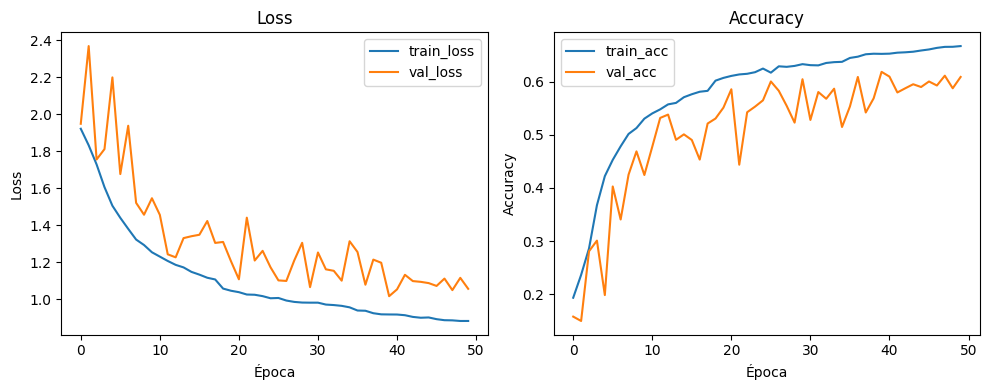

In [13]:
# ============================================================
# 9. Evaluación en test y curvas de entrenamiento
# ============================================================

test_loss, test_acc = model.evaluate(test_ds_p)
print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")

hist = history.history

plt.figure(figsize=(10, 4))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

# Curva de accuracy
plt.subplot(1, 2, 2)
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()


Classification report:

              precision    recall  f1-score   support

       angry       0.48      0.57      0.52       958
   disgusted       0.49      0.40      0.44       111
     fearful       0.43      0.36      0.39      1024
       happy       0.83      0.84      0.84      1774
     neutral       0.55      0.58      0.56      1233
         sad       0.46      0.54      0.49      1247
   surprised       0.82      0.55      0.66       831

    accuracy                           0.60      7178
   macro avg       0.58      0.55      0.56      7178
weighted avg       0.61      0.60      0.60      7178



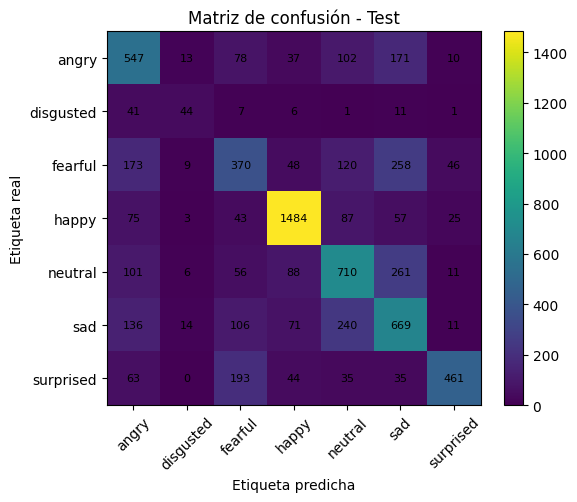

In [14]:
# ============================================================
# 10. Métricas en test: classification_report + matriz de confusión
# ============================================================

y_true = []
y_pred = []

for images, labels in test_ds_p:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión - Test")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Anotar los valores dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8
        )

plt.ylabel("Etiqueta real")
plt.xlabel("Etiqueta predicha")
plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# 11. Distribución de clases en train / val / test
# ============================================================

def contar_labels(ds):
    c = Counter()
    for _, labels in ds:
        c.update(labels.numpy().tolist())
    return c

train_counts = contar_labels(train_ds)
val_counts   = contar_labels(val_ds)
test_counts  = contar_labels(test_ds)

print("Clases:", class_names)

print("\nDistribución en TRAIN:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {train_counts[idx]}")

print("\nDistribución en VAL:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {val_counts[idx]}")

print("\nDistribución en TEST:")
for idx, name in enumerate(class_names):
    print(f"{name:10s}: {test_counts[idx]}")


Clases: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Distribución en TRAIN:
angry     : 3218
disgusted : 363
fearful   : 3285
happy     : 5813
neutral   : 3965
sad       : 3834
surprised : 2490

Distribución en VAL:
angry     : 777
disgusted : 73
fearful   : 812
happy     : 1402
neutral   : 1000
sad       : 996
surprised : 681

Distribución en TEST:
angry     : 958
disgusted : 111
fearful   : 1024
happy     : 1774
neutral   : 1233
sad       : 1247
surprised : 831


In [8]:
import os

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 1) Guardar el modelo entrenado
model_path = "models/baseline_cnn_48x48_gray.keras"
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# 2) Guardar history (loss/acc) como .npz
import numpy as np

hist = history.history
np.savez("results/baseline_history_48x48.npz", **hist)
print("✅ Training history saved to: results/baseline_history_48x48.npz")

# 3) Guardar matriz de confusión como imagen
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - Baseline CNN 48x48")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("results/confusion_matrix_baseline_48x48.png", dpi=150)
plt.close()

print("✅ Confusion matrix saved to: results/confusion_matrix_baseline_48x48.png")


✅ Model saved to: models/baseline_cnn_48x48_gray.keras
✅ Training history saved to: results/baseline_history_48x48.npz
✅ Confusion matrix saved to: results/confusion_matrix_baseline_48x48.png


## Experiment 1 – Baseline CNN (48×48 grayscale, from scratch)

**Setup:**
- Input: 48×48 grayscale facial images
- Model: Custom CNN (3 conv blocks, GlobalAveragePooling, Dense(128), Dropout)
- Loss: SparseCategoricalCrossentropy
- Optimizer: Adam (learning rate = 1e-3)
- Data augmentation: flips, small rotations, zoom, translations
- Class imbalance: class_weight computed from training label distribution
- Callbacks: EarlyStopping (patience=10), ReduceLROnPlateau (patience=5)

**Results (test set):**
- Test accuracy ≈ 0.58
- Macro F1-score ≈ 0.54

Observations:
- `happy` and `surprised` are the best performing classes (F1 ≈ 0.8 and ≈ 0.7).
- `disgusted` greatly benefits from class weighting despite being highly imbalanced.
- Negative emotions like `fearful`, `sad`, and `angry` are often confused with each other and with `neutral`.
- This experiment serves as a baseline CNN trained from scratch on low-resolution (48×48) grayscale images.

